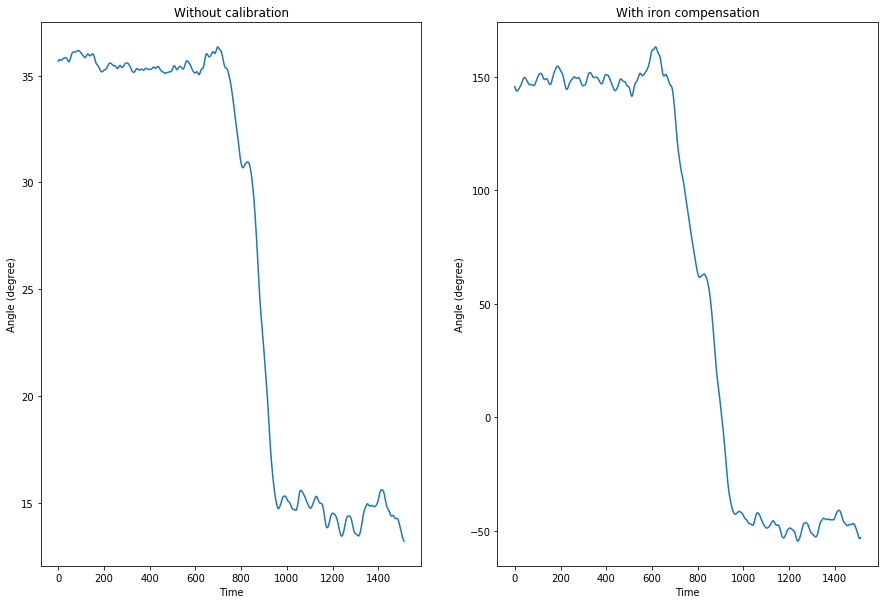

In [14]:
#Preprocessing

import sys
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

import math


# Tilt compensation need accelerometer to calculate the angle
from scipy.signal import butter, filtfilt


def read_file(filename):
    try:
        t, x, y, z = np.loadtxt(filename, delimiter=';', skiprows=1, unpack=True)
        return t, x, y, z
    except:
        print("Error loading file")
        sys.exit()


def convert_unit(mag_x, mag_y, mag_z):
    return 10*mag_x, 10*mag_y, 10*mag_z


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff=6.0, fs=100.0, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    # y = lfilter(b, a, data)
    y = filtfilt(b, a, data)
    return y

# def convert_time(mag_t):
#     dt = np.array(datetime)
#     for index, t in enumerate(mag_t):
#         # mag_t[index] = datetime.fromtimestamp(float(mag_t[index]))
#         np.append(dt, datetime.fromtimestamp(t))
#     return dt


def normalization(ref_arr, new_arr):
    if len(new_arr) > len(ref_arr):
        new_arr = new_arr[: len(ref_arr)]
        return new_arr
    else:
        return new_arr


def tilt_compensation(mag_x, mag_y, mag_z, acc_x, acc_y):
    acc_x = normalization(mag_x, acc_x)
    acc_y = normalization(mag_y, acc_y)
    tmp = np.sqrt(1 - np.square(acc_x) - np.square(acc_y))
    compensated_x = mag_x * (1 - np.square(acc_x)) - mag_y * acc_x * acc_y - mag_z * acc_x * tmp
    compensated_y = mag_y * tmp - mag_z * acc_y
    return compensated_x, compensated_y


# def azimuth_evaluation(acc_x, acc_y, acc_z):
#     sine_phi = -acc_x
#     cosine_phi = math.sqrt(1 - acc_x * acc_x)
#     sine_theta = acc_y / math.sqrt(1 - acc_x * acc_x)
#     cosine_theta = math.sqrt(1 - sine_theta * sine_theta)
#
#     return sine_phi, cosine_phi, sine_theta, cosine_theta


def tilt_compensation_v2(mag_x, mag_y, mag_z, pitch, roll):
    X_h = mag_x * np.cos(pitch) + mag_y * np.sin(roll) * np.sin(pitch) + mag_z * np.cos(roll) * np.sin(pitch)
    Y_h = mag_y * np.cos(roll) - mag_z * np.sin(roll)
    return X_h, Y_h


def tilt_angle(mag_x, acc_x, acc_y, acc_z):
    norm_acc_x = normalization(mag_x, acc_x)
    norm_acc_y = normalization(mag_x, acc_y)
    norm_acc_z = normalization(mag_x, acc_z)
    pitch = np.arctan2(-norm_acc_x, np.sqrt(norm_acc_z * norm_acc_z + norm_acc_y * norm_acc_y))
    roll = np.arctan2(norm_acc_y, np.sqrt(norm_acc_z * norm_acc_z + norm_acc_x * norm_acc_x))

    # pitch = np.arcsin(acc_y, 9.8)
    return pitch, roll

def hard_iron(mag_x, mag_y, mag_z):
    offset_x = (max(mag_x) + min(mag_x)) / 2
    offset_y = (max(mag_y) + min(mag_y)) / 2
    offset_z = (max(mag_z) + min(mag_z)) / 2
    return offset_x, offset_y, offset_z

# Change to do calculation with numpy
def soft_iron(mag_x, mag_y, mag_z):
    offset_x, offset_y, offset_z = hard_iron(mag_x, mag_y, mag_z)
    avg_delta_x = (max(mag_x) - min(mag_x)) / 2
    avg_delta_y = (max(mag_y) - min(mag_y)) / 2
    avg_delta_z = (max(mag_z) - min(mag_z)) / 2
    avg_delta = (avg_delta_x + avg_delta_y + avg_delta_z) / 3

    scale_x = avg_delta / avg_delta_x
    scale_y = avg_delta / avg_delta_y
    scale_z = avg_delta / avg_delta_z

    corrected_x = (mag_x - offset_x) * scale_x
    corrected_y = (mag_y - offset_y) * scale_y
    corrected_z = (mag_z - offset_z) * scale_z
    return corrected_x, corrected_y, corrected_z


def angle_evaluation(corrected_x, corrected_y):
    # angle = 90 - np.arctan2(corrected_y, corrected_x) * 180 / np.pi
    angle = np.arctan2(corrected_x, corrected_y) * 180 / np.pi
    # angle = np.arctan2(corrected_y, corrected_x) * 180 / np.pi
    return angle


def angle_evaluation_v2(corrected_x, corrected_y):
    angles = []
    for index, x in enumerate(corrected_x):
        if math.atan2(corrected_y[index], x) >= 0:
            angles.append(math.atan2(corrected_y[index], x) * (180 / math.pi))
        else:
            angles.append((math.atan2(corrected_y[index], x) + 2 * math.pi) * (180 / math.pi))

    return angles


def absolute_angle(angles):
    previous = 0
    abs_angle = np.zeros(shape=(len(angles), 1))
    for index, angle in enumerate(angles):
        if index == 0:
            abs_angle[index] = 0
            previous = angle
        else:
            abs_angle[index] = angle - previous
            previous = angle

    return abs_angle


def create_dataframe(np_col_name, np_col):
    data_frame = pd.DataFrame()
    data_frame[np_col_name] = pd.Series(np_col)
    return data_frame


def main():
    mag_path = r'G:\PycharmProjects\Magnetometer\MotionLoggerData\20-9-2020\magnetometer.csv'
    acc_path = r'G:\PycharmProjects\Magnetometer\MotionLoggerData\20-9-2020\accelerometer.csv'
    mag_t, mag_x, mag_y, mag_z = read_file(mag_path)

    # convert_time(mag_t)
    # print(type(mag_t))
    # print(mag_t)
    mag_x, mag_y, mag_z = convert_unit(mag_x, mag_y, mag_z)
    acc_t, acc_x, acc_y, acc_z = read_file(acc_path)
    acc_x, acc_y, acc_z = convert_unit(acc_x, acc_y, acc_z)

    # Angle with tilt compensation, soft iron and hard iron caliberation
    pitches, rolls = tilt_angle(mag_x, acc_x, acc_y, acc_z)
    compensated_x, compensated_y = tilt_compensation_v2(mag_x, mag_y, mag_z, pitches, rolls)
    corrected_x, corrected_y, corrected_z = soft_iron(compensated_x, compensated_y, mag_z)
    calib_angles = angle_evaluation_v2(corrected_x, corrected_y)
    calib_abs_angle = absolute_angle(calib_angles)

    #Without iron
    no_iron_angles = angle_evaluation_v2(compensated_x, compensated_y)

    #Without tilt compensation
    untilt_x, untilt_y, utilt_z = soft_iron(mag_x, mag_y, mag_z)
    untilt_angles = angle_evaluation(untilt_x, untilt_y)
    untilt_abs_angles = absolute_angle(untilt_angles)

    #Without caliberation
    uncalib_angles = angle_evaluation(mag_x, mag_y)
    uncalib_abs_angles = absolute_angle(uncalib_angles)

    #Filter test
    uncalib_angles = butter_lowpass_filter(uncalib_angles)
    untilt_angles = butter_lowpass_filter(untilt_angles)
    ###########################################################
    #Simulation
    # sim_points, x_points, y_points = simulate_point(uncalib_angles, 1)
    plt.rcParams['figure.figsize'] = 15, 10
#     fig = plt.figure(figsize = (30,30), dpi = 200, facecolor = 'w')
    fig, axs = plt.subplots(1, 2)

    axs[0].plot(uncalib_angles)
    axs[0].set_title('Without calibration')
    axs[1].plot(untilt_angles)
    axs[1].set_title('With iron compensation')
    
    
#     axs[0, 0].plot(uncalib_angles)
#     axs[0, 0].set_title('Without caliberation')
#     axs[0, 1].plot(untilt_angles)
#     axs[0, 1].set_title('With iron compensation')
    # axs[1, 0] = fig.add_subplot(111, projection='3d')
    # axs[1, 0].scatter(mag_x, mag_y, mag_z)


    # axs[1, 0].plot(mag_t, no_iron_angles)
    # axs[1, 0].set_title('With tilt compensation')
    # axs[1, 1].plot(mag_t, calib_angles)
    # axs[1, 1].set_title('With tilt and iron compensation')
    # plt.plot(mag_t, uncalib_angles)
    # plt.xlabel('Time')
    # plt.ylabel('Angle')

    for ax in axs.flat:
        ax.set(xlabel = 'Time', ylabel = 'Angle (degree)')


    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection = '3d')
    # Axes3D.scatter(mag_x, mag_y, mag_z)
    # ax.scatter(mag_x, mag_y,0 , c=10)
    # ax.scatter(mag_x, mag_z, c=90)
    # for ax in axs.flat:
    #     ax.label_outer()
    plt.show()

if __name__=='__main__':
    main()